## 类和方法（GradCAM，GuidedBackProp）

In [0]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

class GradCAM():
    def __init__(self, model, target_layer, use_cuda):
        self.model = model.eval()
        self.target_layer = target_layer
        self.use_cuda = use_cuda
        self.feature_map = 0
        self.grad = 0
        
        if self.use_cuda:
            self.model = self.model.cuda()
        
        for module in self.model.named_modules():
            if module[0] == target_layer:
                module[1].register_forward_hook(self.save_feature_map)
                module[1].register_backward_hook(self.save_grad)
    
    def save_feature_map(self, module, input, output):
        self.feature_map =  output.detach()
        
    def save_grad(self, module, grad_in, grad_out):
        self.grad = grad_out[0].detach()
        
    def __call__(self, x, index = None):
        x = x.clone()
        if self.use_cuda:
            x = x.cuda()
            
        output = self.model(x)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())
            
        one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot)
        one_hot.requires_grad_()
        if self.use_cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)
            
        self.model.zero_grad()
        
        one_hot.backward()
        
        self.feature_map = self.feature_map.cpu().numpy()[0]
        
        self.weights = np.mean(self.grad.cpu().numpy(), axis = (2, 3))[0, :]
        
        cam = np.sum(self.feature_map * self.weights[:, None, None], axis=0)
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (x.size()[-1], x.size()[-2]))
        return cam, index

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

class GuidedBackProp():
    def __init__(self, model, use_cuda):
        self.model = model.eval()
        self.use_cuda  = use_cuda
        if self.use_cuda:
            self.model = self.model.cuda()
        
        for module in self.model.named_modules():
            module[1].register_backward_hook(self.bp_relu)
        
    def bp_relu(self, module, grad_in, grad_out):
        if isinstance(module, nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.0), )
    
    def __call__(self, x, index = None):
        x = x.clone()
        if self.use_cuda:
            x = x.cuda()
        x.requires_grad_()
        output = self.model(x)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())
            
        one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot)
        one_hot.requires_grad_()
        if self.use_cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)
            
        one_hot.backward()
        result = x.grad.cpu().numpy()[0]
        result = np.transpose(result, (1,2,0))
        return result, index

def arrange_img(img):
    img = np.maximum(img, 0)
    res = img - img.min()
    res /= res.max()
    res = np.uint8(res*255)
    return res

## 可视化

In [0]:
import matplotlib.pyplot as plt
from torchvision import models, transforms, utils

def run(model, image_path, index = None, cuda = False):
    # 图像处理
    raw_image = cv2.imread(image_path)[..., ::-1]
    raw_image = cv2.resize(raw_image, (224, 224))
    image = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
    ])(raw_image).unsqueeze(0)

    # GradCAM
    print("GradCAM:")
    grad_cam = GradCAM(model, 'layer4.2', use_cuda = cuda)
    cam, _ = grad_cam(image, index)
    cam_on_image = show_cam_on_image(raw_image/255, cam)
    plt.imshow(cam_on_image)
    plt.show()

    # GuidedBackProp
    print("GuidedBackProp:")
    guided_bp = GuidedBackProp(model, use_cuda = cuda)
    guided_cam, _ = guided_bp(image, index)
    plt.imshow(arrange_img(guided_cam))
    plt.show()

In [0]:
model = models.resnet50(pretrained = True)

GradCAM:


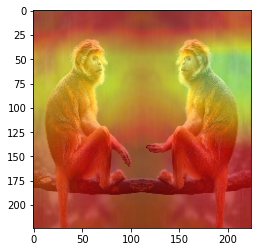

GuidedBackProp:


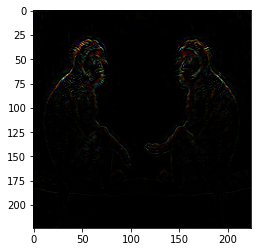

In [6]:
### 输入模型， 图片， 关注的类标签
run(model, './timg.jpg', index = None)